# 使用多层感知机实现MNIST Multilayer Perceptron (MLP)


我的第一个机器学习案例. 
多层感知机实现英文手写识别。使用 PyTorch 实现。
本代码实现，没有参考mnist的PyTorch实现，主要参考《神经网络与深度学习》版本中:Michael Nielsen的原理实现。
该书采用手写代码实现，下文采用PyTorch实现。
代码主要参考《madewithml》中文版代码

**注意**： 本文仅是用 PyTorch 对 MLPs 做介绍，因此我们不会按照机器学习技巧去简化（训练/测试拆分时的类平衡，验证集合，及早终止等）。我们将在下一文中实现最佳实践。

sanit.peng

# 概览 Overview


$z_2 = XW_1$

$a_2 = f(z_2)$

$z_3 = a_2W_2$

$\hat{y} = softmax(z_3)$ # 类别

*其中*：
* $X$ = 输入 | $\in \mathbb{R}^{NXD}$ ($D$ 是特征的数量)
* $W_1$ = 第1层权重 | $\in \mathbb{R}^{DXH}$ ($H$ 是隐含层在第1层的单元数量)
* $z_2$ = 第1层权重的输出  $\in \mathbb{R}^{NXH}$
* $f$ = 非线性激活函数
* $a_2$ = 应用在第1层输出的激活值 | $\in \mathbb{R}^{NXH}$
* $W_2$ = 第2层权重 | $\in \mathbb{R}^{HXC}$ ($C$ 是类别数量)
* $\hat{y}$ = 预测 | $\in \mathbb{R}^{NXC}$ ($N$ 是采样数量)

这是简单的2层 MLP. 

* **目的：**  基于给定的输入预测类别的概率。因为非线性数据，模型复杂度引入了非线性。
* **优势：**
  * 能很好的处理非线性模式。
* **劣势：**
  * 容易过拟合。
  * 计算精度取决于网络体积。
  * 不容易解释。
* **多样性：** 我们之后看到的未来神经网略架构使用 MLP 作为前馈操作（非线性操作之前的仿射变换）的一个模块单元。

# 训练 Training

*步骤*：$

0. mnist数据装载，将图片数据变为（28*28）= 784个输入的数据， 整个数据组织成[N, 784]的一个2维张量和[N]的一个1维张量存放标签。
    
    模型设计：1个隐藏层30个神经元，随机梯度下降，交叉熵计算损失，未减枝。$
    
    超参数:  学习率3.0
    
    
1. 随机初始化模型权重 $W$ （我们在之后的课程中将介绍更有效的初始化策略）。
2. 给予模型输入 $X$ 得到概率。
3. 比较预测值 $\hat{y}$ 和真实值 $y$ （，使用目标（代价）函数决定损失 $J$。分类任务常用的目标函数是交叉熵损失(Cross Entropy Loss)。 
  * $z_2 = XW_1$
  * $a_2 = max(0, z_2)$ # ReLU 激活函数, Sigmoid 激活函数对最后的识别率影响很大，ReLU大概为20%， Sigmoid为93%
  * $z_3 = a_2W_2$
  * $\hat{y} = softmax(z_3)$
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) $
4. 计算损失 $J(\theta)$ w.r.t 对模型权重的梯度。 
   * $ \frac{\partial{J}}{\partial{W_{2j}}} = a_2\hat{y}, \frac{\partial{J}}{\partial{W_{2y}}} = a_2(\hat{y}-1) $
   * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_2}}  \frac{\partial{a_2}}{\partial{z_2}}  \frac{\partial{z_2}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $
   
5. 应用反向传播法（backpropagation）到使用梯度下降更新权重 $W$ 。这些更新将减少错误类别（j）的概率，增加正确类别（y）的概率。
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. 重复步骤2-4，直到模型收敛。

# 数据 Data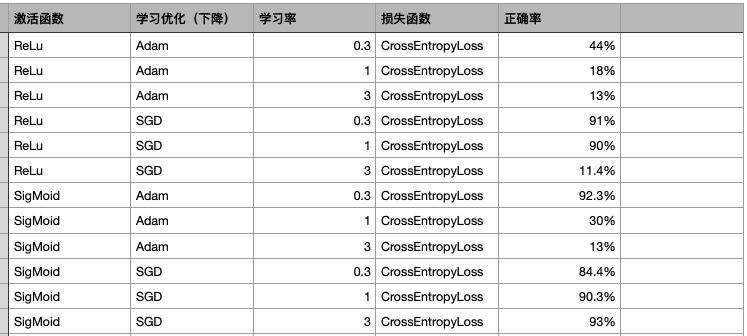
从数据可以看出，激活函数选择，学习路径，和超参数的选择对整个结果有很大影响。当按照《神》一文中选择得到的效果最好93%，但依然无法达到文中所说96%。因此需要：1.理解各种函数和参数选择的方法 2.理解层数（深度）和神经元多少的影响。本文未做实验。
未实验： tanh, 神经元个数，超参数如何选择。。。。$
上图是200次epoch结果，将epoch提高到2000次，成功率98.2% 但不知道是否会过拟合。

# 数据 Data

加载mnist数据

In [209]:
# Load PyTorch library
!pip3 install torch torchvision

In [210]:
#for MacOS
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




In [211]:
# load mnist data, rewriten from mnist_loader
import pandas as pd 
import pickle

import gzip



def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('../data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)



def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e



In [212]:
tr_d, va_d, te_d = load_data()

In [213]:
tr_d

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8]))

In [214]:
len(tr_d[0][0])

784

In [215]:
type(tr_d[0]),tr_d[0].shape,tr_d[1].shape

(numpy.ndarray, (50000, 784), (50000,))

In [216]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [442]:
# Arguments
args = Namespace(
    seed=1234,
    dimensions=784,
    num_classes=10,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=30,
    #learning_rate=1e-0,
    learning_rate=3,
    regularization=1e-3,
    num_epochs=200,
)



In [443]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(tr_d[0]).float()
y_train = torch.from_numpy(tr_d[1]).long()

In [444]:
X_train.dim(), y_train.dim()

(2, 1)

In [445]:
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [446]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [447]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        #a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        a_1 = torch.sigmoid(self.fc1(x_in)) # activaton function added!
        
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [448]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)>


In [449]:
# Optimization,
#损失函数 和 学习路径
loss_fn = nn.CrossEntropyLoss()


In [450]:
#optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)


In [451]:
#损失函数 和 学习路径SGD
optimizer = optim.SGD(model.parameters(), lr=args.learning_rate) # SGD optimizer (usually better than SGD)


In [452]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [453]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 2.3302 | acc: 10.3%
epoch: 20 | loss: 0.7914 | acc: 78.9%
epoch: 40 | loss: 0.5351 | acc: 82.1%
epoch: 60 | loss: 0.3766 | acc: 89.4%
epoch: 80 | loss: 0.3277 | acc: 90.9%
epoch: 100 | loss: 0.3024 | acc: 91.4%
epoch: 120 | loss: 0.2863 | acc: 91.8%
epoch: 140 | loss: 0.2672 | acc: 92.4%
epoch: 160 | loss: 0.2526 | acc: 92.8%
epoch: 180 | loss: 0.2414 | acc: 93.2%
epoch: 200 | loss: 0.2318 | acc: 93.4%
epoch: 220 | loss: 0.2233 | acc: 93.7%
epoch: 240 | loss: 0.2157 | acc: 93.9%
epoch: 260 | loss: 0.2087 | acc: 94.1%
epoch: 280 | loss: 0.2023 | acc: 94.2%
epoch: 300 | loss: 0.1965 | acc: 94.4%
epoch: 320 | loss: 0.1911 | acc: 94.5%
epoch: 340 | loss: 0.1860 | acc: 94.7%
epoch: 360 | loss: 0.1813 | acc: 94.8%
epoch: 380 | loss: 0.1769 | acc: 94.9%
epoch: 400 | loss: 0.1727 | acc: 95.1%
epoch: 420 | loss: 0.1688 | acc: 95.2%
epoch: 440 | loss: 0.1651 | acc: 95.3%
epoch: 460 | loss: 0.1616 | acc: 95.4%
epoch: 480 | loss: 0.1582 | acc: 95.5%
epoch: 500 | loss: 0.1551 | ac

In [250]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)


In [251]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)

print ("train acc: {0:.1f}%".format(train_acc))

train acc: 51.1%


In [252]:
#####################################################################

In [253]:
#开始测试，为了不影响参数执行eval(),当之下train()的时候会继续影响参数
model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)

In [254]:
# Convert to PyTorch tensors
X_test = torch.from_numpy(te_d[0]).float()
y_test = torch.from_numpy(te_d[1]).long()

In [255]:
X_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [256]:
y_test

tensor([7, 2, 1,  ..., 4, 5, 6])

In [257]:
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 51.1%, test acc: 51.0%


In [258]:
index = 1

In [259]:
X_test[index].size(), X_test.size()

(torch.Size([784]), torch.Size([10000, 784]))

In [260]:
#X_test[index].unsqueeze(0)
#X_test[index].unsqueeze(0).size()

In [261]:
#去某个测试数据，同时重新扩充为2维张量
test_image = X_test[index].unsqueeze(0)
test_y = y_test[index].unsqueeze(0)

y_pred = model(test_image, apply_softmax=True)

print(y_pred, test_y)



tensor([[1.7924e-02, 1.5606e-08, 1.3993e-01, 2.3542e-01, 9.5471e-03, 1.8597e-01,
         2.0461e-01, 2.2082e-03, 1.9624e-01, 8.1462e-03]],
       grad_fn=<SoftmaxBackward>) tensor([2])


In [262]:
# Top nationality
y_prob, indices = y_pred.max(dim=1)
#index = indices.item()
print(y_prob)
print(indices, indices.item())

probability = y_prob.item()
print('probability', probability)

tensor([0.2354], grad_fn=<MaxBackward0>)
tensor([3]) 3
probability 0.23542103171348572
